In [1]:
# TODO: 
# - Deal with Apple users!
# - Deal with multiple devices per user!

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datenspende_who5 import styling
from textwrap import wrap

In [3]:
LABEL = {65: 'Ruhepuls', 9: 'Aktivität', 43: 'Schlafdauer', 52: 'Einschlafzeit', 53: 'Aufwachzeit'}    

In [4]:
def bin_vitals(df):
    
    df = pd.read_feather('../data/02_processed/vitals.feather')

    df.loc[df.vitalid == 9, 'value_binned'] = np.round(df[df.vitalid == 9].value, -3) 
    df.loc[df.vitalid == 65, 'value_binned'] = np.round(df[df.vitalid == 65].value, 0)
    df.loc[df.vitalid == 43, 'value_binned'] = np.round(df[df.vitalid == 43].value / 15, 0) * 15
    df.loc[df.vitalid == 52, 'value_binned'] = np.round(df[df.vitalid == 52].value / 2, 1) * 2
    df.loc[df.vitalid == 53, 'value_binned'] = np.round(df[df.vitalid == 53].value / 2, 1) * 2

    df.loc[(df.vitalid == 65) & ((df.value_binned > 90) | (df.value_binned < 45)), 'value'] = np.nan
    df.loc[(df.vitalid == 9) & ((df.value_binned > 20000) | (df.value_binned < 1000)), 'value'] = np.nan
    df.loc[(df.vitalid == 43) & ((df.value_binned > 600) | (df.value_binned < 120)), 'value'] = np.nan
    df.loc[(df.vitalid == 52) & ((df.value_binned > 2) | (df.value_binned < -3)), 'value'] = np.nan
    df.loc[(df.vitalid == 53) & ((df.value_binned < 4.5) | (df.value_binned > 10)), 'value'] = np.nan

    df.dropna(inplace=True)

    return df


def load():
    
    answers = pd.read_feather('../data/02_processed/who5_responses.feather')
    vitals = pd.read_feather('../data/02_processed/vitals.feather')
    vitals = bin_vitals(vitals)
    
    df = pd.merge(answers, vitals, on=['user_id', 'date'])
    
    return df


def average_vitals_per_survey_response(df):

    df = df.groupby(['question', 'vitalid', 'choice_id']).value.agg(['mean', 'std', 'count'])
    df['err'] = df['std'] / np.sqrt(df['count'])
    
    return df


def average_survey_response_per_vital(df):

    df = df.groupby(['question', 'vitalid', 'value_binned']).choice_id.agg(['mean', 'std', 'count'])
    df['err'] = df['std'] / np.sqrt(df['count'])
    df.dropna(inplace=True)
    
    return df


def plot_average_vitals_per_survey_response(df, outfile='../output/1.02a-average_vital_per_survey_response.pdf'):
    
    df = average_vitals_per_survey_response(df)
    
    f, axarr = plt.subplots(5, 5, figsize=(10, 7), sharey='row', sharex=True)

    for row_id, question in enumerate([49, 50, 54, 55, 56]):

        axarr[0, row_id].set_title(get_title(question, 30), size=8)

        for col_id, vital in enumerate([65, 9, 43, 52, 53]):
            plot_data = df.loc[question, vital]
            axarr[col_id, row_id].errorbar(plot_data.index, plot_data['mean'], yerr=plot_data['err'], fmt='o', markersize=4)
            axarr[col_id, 0].set_ylabel(LABEL[vital]) 

    for ax in axarr.flatten():
        styling.hide_and_move_axis(ax)
        ax.set_xticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.savefig(outfile)
    

def get_title(question, wrap):
    
    title = data[data.question == question].description.values[0]
    title = '\n'.join(wrap(title, wrap))

    return title
    
def plot_average_survey_response_per_vital(df, outfile='../output/1.02b-average_survey_response_per_vital.pdf'):
    
    df = average_survey_response_per_vital(df)
    
    f, axarr = plt.subplots(5, 5, figsize=(10, 7), sharex='col')

    for row_id, question in enumerate([49, 50, 54, 55, 56]):

        axarr[row_id, 0].set_ylabel(get_title(question, 22), size=8)
        
        for col_id, vital in enumerate([65, 9, 43, 52, 53]):
            plot_data = df.loc[question, vital]
            axarr[row_id, col_id].errorbar(plot_data.index, plot_data['mean'], yerr=plot_data['err'], fmt='o', markersize=4)
            axarr[-1, col_id].set_xlabel(LABEL[vital]) 

    for ax in axarr.flatten():
        styling.hide_and_move_axis(ax)

    plt.tight_layout()
    plt.savefig(outfile)
    

In [5]:
data = load()

# Average vital data for each survey response

In [ ]:
plot_average_vitals_per_survey_response(data)

# Average survey response for given vital data

In [ ]:
plot_average_survey_response_per_vital(data)

# Sandbox

In [74]:
df = average_survey_response_per_vital(data)

In [252]:
rhr = data[data.vitalid == 65]
steps = data[data.vitalid == 9]

combined = pd.merge(rhr, steps, on=['user_id', 'date', 'question', 'choice_id', 'description'])

cb = combined.groupby(['value_binned_x', 'value_binned_y']).choice_id.agg(['mean', 'std', 'count'])

x_values = np.arange(45, 80, 1)
y_values = np.arange(1000, 15001, 1000)

results = np.zeros((len(x_values), len(y_values)))

for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        if (x, y) in cb.index and cb.loc[x, y]['count'] > 200:
                results[i, j] = cb.loc[x, y]['mean']
        else:
            results[i, j] = np.nan

/var/folders/cm/6ltwrgb55_l43f5w6rzn62zc0000gn/T/ipykernel_25074/485791706.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


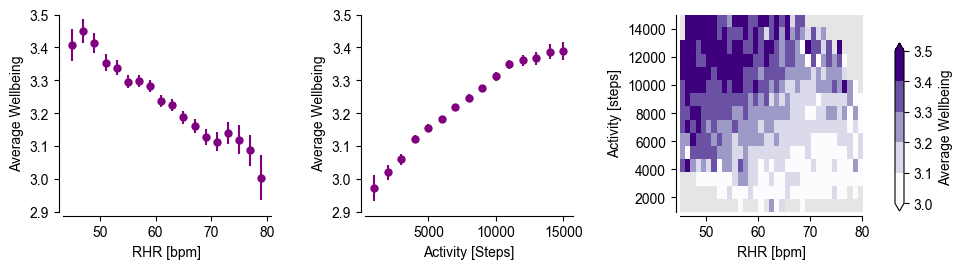

In [372]:
f, axarr = plt.subplots(1, 3, figsize=(9, 2.8))

ax0, ax1, ax2 = axarr

plot = df.loc[60, 65].loc[:80:2]
ax0.errorbar(plot.index, plot['mean'], yerr=1.96 * plot.err, fmt='o', markersize=5, c='purple')

plot = df.loc[60, 9].loc[:15000]
ax1.errorbar(plot.index, plot['mean'], yerr=1.96 * plot.err, fmt='o', markersize=5, c='purple')    

ax = axarr[2]
cmap = matplotlib.colormaps['Purples']
cmap = cmap.resampled(5)
cmap.set_bad('0.9')

axarr[0].set_xlabel('RHR [bpm]')
axarr[1].set_xlabel('Activity [Steps]')

axarr[0].set_ylabel('Average Wellbeing')
axarr[1].set_ylabel('Average Wellbeing')

axarr[0].set_ylim(2.9, 3.5)
axarr[1].set_ylim(2.9, 3.5)

c = ax.imshow(results.T, origin='lower', cmap=cmap, vmin=3, vmax=3.5, aspect=0.0027, extent=[45, 80, 1000, 15000])
styling.hide_and_move_axis(ax)
ax.set_xlabel('RHR [bpm]')
ax.set_ylabel('Activity [steps]')

ax = f.add_axes([1, 0.225, 0.01, 0.6])

plt.colorbar(c, extend='both', cax=ax, label='Average Wellbeing')
for ax in axarr:
    styling.hide_and_move_axis(ax)

plt.tight_layout()

plt.savefig('../output/1.02c-average_wellbeing.jpg', dpi=400, bbox_inches='tight')